# Linear regression 
In this exercise, you will learn how to perform linear regression using:
* Analytical methods (MLE/OLS)
* Gradient descent with TensorFlow 2.0

## Task
Answer the multiple-choice questions formatted as such:
```
# Question x: Sum two numbers.
# Option 1: sum = a + b
# Option 2: sum = a - b
# Option 3: sum = a * b
```
Simply copy the code corresponding to the option which you think is correct. 

If no options are given, you will need to fill in the `???`, e.g.
```
# Question x: Sum two numbers.
# sum = ???
```

Have fun! :D

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)  # Ensure that we're using "2.0.0-rc1"

2.0.0-rc1


In [2]:
# Import dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

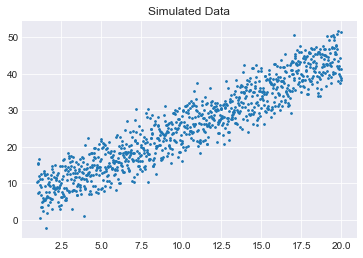

In [3]:
# Generate samples
n_samples = 1000  # Number of samples (datapoints)

w = np.array([2, 5]).reshape(1, 2)  # Ground truth weight
sigma = 4  # Ground truth variance of normally distributed errors, epsilon_k ~ N(0, sigma)

train_x = np.concatenate([np.linspace(1, 20, n_samples).reshape(n_samples, 1), 
                          np.ones((n_samples, 1))], 
                         axis=-1)
# Question 1: Apply noise-measured linear model.
train_y = np.random.normal(w @ train_x.T, sigma)

# Plot the data points
plt.figure()
plt.scatter(train_x[:,0], train_y, label='Samples', s=3)
plt.title('Simulated Data')
plt.show()

# Optimize weights analytically
In problem 1.1 of the exercise, we derived the estimated $\hat{\mathbf{w}}$ using maximum likelihood estimation (MLE).

As it turns out... **The maximum likelihood estimator is identical to the ordinary least squares (OLS) estimator** under the normality assumption for the error terms.

\begin{align}
\hat{\mathbf{w}} &= \operatorname {argmin} _{w\in \mathbb {R} ^{2}} \text{(sum of squared errors)} \\
&= \operatorname {argmax} _{w\in \mathbb {R} ^{2}} \text{(maximum likelihood)} \\
&= \mathbf{y}\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}
\end{align}
![MindBlownUrl](https://media1.tenor.com/images/38b3102d576053b22c16f61ddb669672/tenor.gif?itemid=4740219 "mind blown")


In [4]:
# Question 2: Analytical solution to linear regression.
w_est = train_y @ train_x @ np.linalg.inv(train_x.T @ train_x)

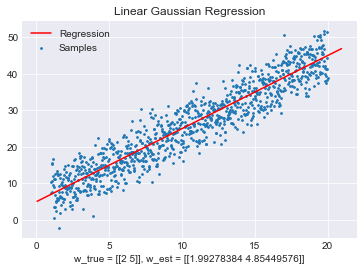

In [5]:
# Plot the line and data
plt.figure()
plt.scatter(train_x[:,0], train_y, label='Samples', s=3)
plt.title('Linear Gaussian Regression')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = w[:,1] + w[:,0] * x_vals
plt.plot(x_vals, y_vals, 'r-', label='Regression')
plt.legend()
plt.xlabel('w_true = %s, w_est = %s' % (w, w_est))
plt.show()

As you can see, the estimated $\hat{\mathbf{w}}$ from the analytical solution are quite close to the true $\mathbf{w}$!

# Numerical solution to linear regression
One drawback of the analytical solution is that as our number of samples $N$ increases, the computational cost scales poorly since the time complexity of inverting our $N\times N$ matrix $\mathbf{X}^\top \mathbf{X}$, is $\mathcal{O}(N^3)$.

Another way to optimize our weights is to use **gradient descent**. It is fast, easy to implement, and is a generic optimization technique that can be applied even to more complex loss functions than our current likelihood formulation.

![gd](https://media.giphy.com/media/O9rcZVmRcEGqI/giphy.gif "gradient descent")

In problem 1.3 of the exercise, we have shown that maximizing the log-likelihood is identical to minimizing the mean squared error (MSE). Therefore we can use the MSE as the loss function in our stochastic gradient descent (SGD) scheme:
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \mathbf{w}\mathbf{x}_i^T)^2
$$

In [9]:
# Try playing around with different learning rates and iterations to see what will happen.
learning_r = 4e-3
iterations = 500

# Try different initializations of w.
w0, w1 = 1, 6
w_est = tf.Variable(np.array([w0, w1], dtype="float64").reshape(1, 2), 
                    name="weight") 

@tf.function
def loss_function(w, x, y):
    # Question 3: Compute the predicted y according to the current estimate of w.
    pred = tf.matmul(w, tf.transpose(x))
    # Question 4: Compute the mean squared error (MSE).
    squared_errors = tf.square(y - pred)
    sum_of_squared_errors = tf.reduce_sum(squared_errors)
    mean_squared_error = sum_of_squared_errors / n_samples
    return mean_squared_error

optimizer = tf.keras.optimizers.SGD(learning_r)
tf_x, tf_y = train_x, train_y

# Book-keeping
loss_history = np.zeros(shape=(iterations,))
weight_history = np.zeros(shape=(iterations, 2))

for i in range(iterations):
    # Apply minimize, passing in the loss function and variables
    optimizer.minimize(lambda: loss_function(w_est, tf_x, tf_y), var_list=[w_est])
    loss_history[i] = loss_function(w_est, tf_x, tf_y).numpy()
    weight_history[i] = w_est.numpy()
print('Estimated weight: %s' % (w_est.numpy()))
print('True weight: %s' % (w))

Estimated weight: [[1.95413279 5.37050589]]
True weight: [[2 5]]


**Note**: The [`@tf.function`](https://www.tensorflow.org/beta/tutorials/eager/tf_function) decorator is used to convert Python code into a computational graph automatically, using AutoGraph. However, there may be a warning when you run it that looks like:

```
WARNING: Entity <function loss_function at 0x137e7d840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
```
Do not worry about this; it just means that there was a problem with AutoGraph, but it should not affect your results.

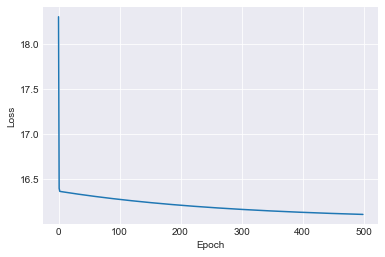

In [7]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

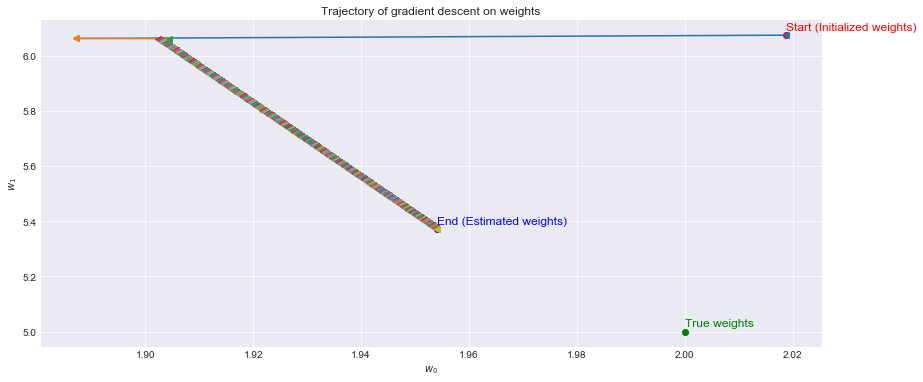

In [8]:
def plot_labeled_point(x, y, label, color):
    plt.plot(x, y, marker="o", color=color)
    plt.text(x, y + 0.02, label, fontsize=12, color=color)

plt.figure(figsize=(14,6))
prev_w0, prev_w1 = weight_history[0]
plot_labeled_point(w[0][0], w[0][1], "True weights", "g")
plot_labeled_point(prev_w0, prev_w1, "Start (Initialized weights)", "r")
plot_labeled_point(*weight_history[-1], "End (Estimated weights)", "b")
for w0, w1 in weight_history[1:]:
    plt.plot([prev_w0, w0], [prev_w1, w1], '<-')
    prev_w0, prev_w1 = w0, w1
plt.xlabel(r'$w_0$')
plt.ylabel(r'$w_1$')
plt.title('Trajectory of gradient descent on weights')
plt.show()


# Extra material
- [Solving linear regression via matrix decomposition](https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/) e.g. QR decomposition, SVD (singular-value decomposition)
- [Guide to TensorFlow AutoGraph](https://www.tensorflow.org/guide/autograph)